# Humanoid Model Predictive Control

The following notebook is part of the final project from the course of *<a href="https://scaron.info/robotics-mva/">Robotics</a>* from the master *Mathématiques, Vision et Apprendissage (MVA)* - *ENS Paris Saclay* - France


# Reproduce the formulation and resolution of Model Predictive Control as a QP problem

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import qpsolvers
from pinocchio import SE3

from scripts.humanoid_mpc import MPCParams, feet, foot, MPCForce
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
import time

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## General Problem

In [26]:
T = 0.02
g = 9.87
h_CoM = 0.44
N = 50

robot_feet = feet(spread=0.05, length=0.04, width=0.04, right=foot(-0.04, 0), left=foot(+0.04, 0))
 

mpc = MPCParams(T, N, h_CoM, g, robot_feet, duration=21, step_duration=3)

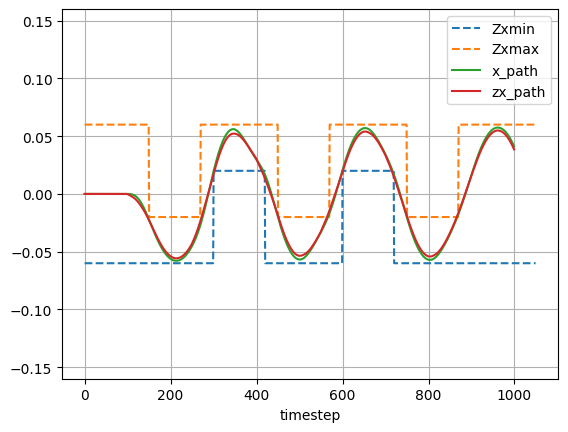

In [27]:
Zxmin, Zxmax = mpc.Zmin[0], mpc.Zmax[0]
x_path, zx_path, jerks = mpc.solve(Zxmin, Zxmax, coord='x')

plt.plot(Zxmin,'--', label= 'Zxmin')
plt.plot(Zxmax,'--', label="Zxmax")
plt.plot(x_path, label="x_path")
plt.plot(zx_path, label="zx_path")
plt.xlabel('timestep')
plt.ylim(min(Zxmin)-0.1, max(Zxmax)+0.1)

plt.legend()
plt.grid()

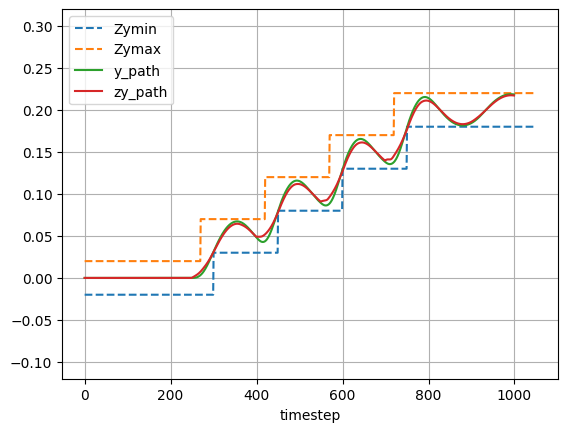

In [28]:
Zymin, Zymax = mpc.Zmin[1], mpc.Zmax[1]
y_path, zy_path, jerks = mpc.solve(Zymin, Zymax, coord="y") 

plt.plot(Zymin,'--', label= 'Zymin')
plt.plot(Zymax,'--', label="Zymax")
plt.plot(y_path, label="y_path")
plt.plot(zy_path, label="zy_path")
plt.xlabel('timestep')
plt.ylim(min(Zymin)-0.1, max(Zymax)+0.1)

plt.legend()
plt.grid()

## Applying force

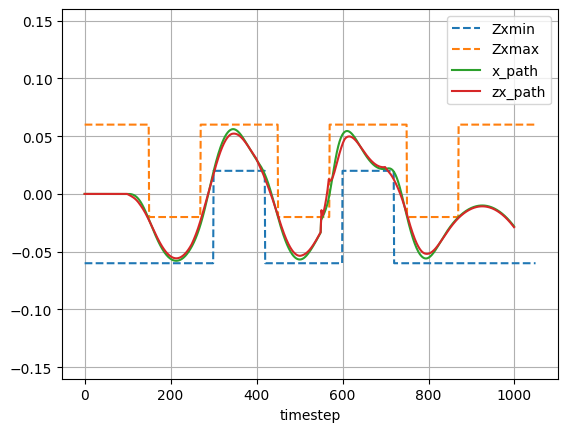

In [64]:
mpc = MPCForce(T, N, h_CoM, g, robot_feet, duration=21, step_duration=3, force=0.5)

Zxmin, Zxmax = mpc.Zmin[0], mpc.Zmax[0]
x_path, zx_path, jerks = mpc.solve(Zxmin, Zxmax, coord='x', force_k=550)

plt.plot(Zxmin,'--', label= 'Zxmin')
plt.plot(Zxmax,'--', label="Zxmax")
plt.plot(x_path, label="x_path")
plt.plot(zx_path, label="zx_path")
plt.xlabel('timestep')
plt.ylim(min(Zxmin)-0.1, max(Zxmax)+0.1)

plt.legend()
plt.grid()

## Comparing Different solvers:


In [66]:
# mpc = MPCParams(T, N, h_CoM, g, duration=8)
        
# Zmin, Zmax = mpc.Zmin, mpc.Zmax
# plt.plot(Zmin,'--', label= 'Zmin')
# plt.plot(Zmax,'--', label="Zmax")
# sparse=True
# for solver in qpsolvers.available_solvers[::-1]:
#     print(solver)
#     x_path, z_path, jerks = mpc.solve(Zmin, Zmax, solver) 
#     plt.plot(z_path, label=f"z_path with {solver}")
#     plt.xlabel('timestep')
#     plt.ylim(min(Zmin)-0.1, max(Zmax)+0.1)

#     plt.legend()
#     plt.grid()

print("Other solvers are not working well because the matrix is not sparse.")


Other solvers are not working well because the matrix is not sparse.


## Sphere Visualization

In [1]:
viz = MeshcatVisualizer()
viz.addSphere('CoM', radius=.01, color='red')
viz.addSphere('CoP', radius=.01, color='green')

In [283]:
for x_CoM, zx_CoP, y_CoM, zy_CoP in zip(x_path, zx_path, y_path, zy_path):
    displacement_CoM = SE3(np.eye(3), np.array([x_CoM, y_CoM, h_CoM]))
    displacement_CoP = SE3(np.eye(3), np.array([zx_CoP, zy_CoP, 0]))
    viz.applyConfiguration('CoM', displacement_CoM)
    viz.applyConfiguration('CoP', displacement_CoP)
    time.sleep(T)

## Steps Visualization

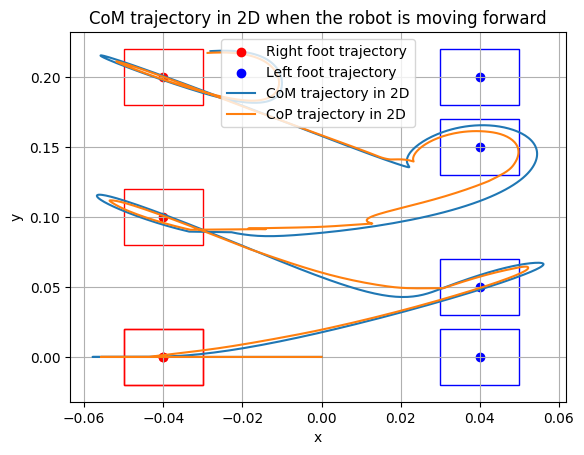

In [65]:
from matplotlib.patches import Rectangle

feet_tracker = mpc.feet_tracker
left_foot = mpc.left_trajectory
right_foot = mpc.right_trajectory

zy__right_path = [pos[1] for pos in right_foot]
zy__left_path = [pos[1] for pos in left_foot]

zx__right_path = [pos[0] for pos in right_foot]
zx__left_path = [pos[0] for pos in left_foot]


plt.scatter(zx__right_path, zy__right_path, c="r", label="Right foot trajectory")
plt.scatter(zx__left_path, zy__left_path, c="b", label="Left foot trajectory")
plt.plot(x_path, y_path, label="CoM trajectory in 2D")
plt.plot(zx_path, zy_path, label="CoP trajectory in 2D")
# draw a bounding box of each zx__right_path and zx__left_path pair
for i in range(len(zx__right_path)):
    rect = Rectangle((zx__right_path[i]-0.01, zy__right_path[i]-0.02), 0.02, 0.04, fill=False, color="r")
    plt.gca().add_patch(rect)
    rect = Rectangle((zx__left_path[i]-0.01, zy__left_path[i]-0.02), 0.02, 0.04, fill=False, color="b")
    plt.gca().add_patch(rect)
plt.xlabel('x')
plt.ylabel('y')
plt.title("CoM trajectory in 2D when the robot is moving forward")
# legend in the top middle
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center')

plt.grid()
plt.show()

# Visualize on robot

In [287]:

"""SigmaBan humanoid standing on two feet."""

import meshcat_shapes
import numpy as np
import pinocchio as pin
import qpsolvers
from loop_rate_limiters import RateLimiter

import pink
from pink import solve_ik
from pink.tasks import FrameTask, PostureTask

try:
    from robot_descriptions.loaders.pinocchio import load_robot_description
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        "Examples need robot_descriptions, "
        "try `pip install robot_descriptions`"
    )


robot = load_robot_description(
    "sigmaban_description", root_joint=pin.JointModelFreeFlyer()
)
viz = pin.visualize.MeshcatVisualizer(
    robot.model, robot.collision_model, robot.visual_model
)
robot.setVisualizer(viz, init=False)
viz.initViewer(open=True)
viz.loadViewerModel()


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7024/static/


In [288]:
configuration = pink.Configuration(robot.model, robot.data, robot.q0)
viz.display(configuration.q)
viewer = viz.viewer
left_foot_task = FrameTask(
    "left_foot_tip",
    position_cost=1.0,
    orientation_cost=1.0,
)
torso_task = FrameTask(
    "torso",
    position_cost=1.0,
    orientation_cost=1.0,
)
right_foot_task = FrameTask(
    "right_foot_tip",
    position_cost=1.0,
    orientation_cost=1.0,
)
posture_task = PostureTask(
    cost=1e-2,  # [cost] / [rad]
)
tasks = [left_foot_task, torso_task, right_foot_task, posture_task]

torso_pose = configuration.get_transform_frame_to_world("torso").copy()
# torso_pose.translation[2] += 1.0
torso_task.set_target(torso_pose)
posture_task.set_target_from_configuration(configuration)

transform_left_foot_tip_target_to_init = pin.SE3(
    np.eye(3), np.array([0, 0, 0])
)
transform_right_foot_tip_target_to_init = pin.SE3(
    np.eye(3), np.array([0, 0, 0])
)

left_foot_task.set_target(
    configuration.get_transform_frame_to_world("left_foot_tip")
* transform_left_foot_tip_target_to_init
)
right_foot_task.set_target(
    configuration.get_transform_frame_to_world("right_foot_tip")
    * transform_right_foot_tip_target_to_init
    )
torso_task.set_target(configuration.get_transform_frame_to_world("torso"))

# Display targets
meshcat_shapes.frame(viewer["left_foot_target"], opacity=0.5)
meshcat_shapes.frame(viewer["right_foot_target"], opacity=0.5)
meshcat_shapes.frame(viewer["torso_target"], opacity=0.5)
viewer["left_foot_target"].set_transform(
    left_foot_task.transform_target_to_world.np
)
viewer["right_foot_target"].set_transform(
    right_foot_task.transform_target_to_world.np
)
viewer["torso_target"].set_transform(
    torso_task.transform_target_to_world.np
)

# Select QP solver
solver = qpsolvers.available_solvers[0]
if "quadprog" in qpsolvers.available_solvers:
    solver = "quadprog"

rate = RateLimiter(frequency=200.0, warn=False)
dt = rate.period
t = 0.0  # [s]
    

In [289]:
prev_torso_x= 0
prev_torso_y = 0
right_step = 0
left_step = 0
current_foot = "right"

for i in range(1,len(x_path)):
    torso_x = x_path[i]
    torso_y = y_path[i]

    torso_x_displacement = torso_x - prev_torso_x
    prev_torso_x = torso_x
    torso_y_displacement = torso_y - prev_torso_y
    prev_torso_y = torso_y

    torso_task.set_target(
        configuration.get_transform_frame_to_world("torso")
        * pin.SE3(np.eye(3), np.array([torso_y_displacement, torso_x_displacement, 0]))
    )

    posture_task.set_target_from_configuration(configuration)

    took_step = feet_tracker[i] != feet_tracker[i-1]
    left, right = feet_tracker[i]
    both_feet_on_the_ground = (right and left)
    if (took_step).any():
        if  both_feet_on_the_ground:
            if current_foot == "right":
                right_step += 1
                current_foot = "left"
                displacement_y = zy__right_path[right_step] - zy__right_path[right_step-1]
                right_foot_task.set_target(
                    configuration.get_transform_frame_to_world("right_foot_tip")
                    * pin.SE3(np.eye(3), np.array([displacement_y, 0, 0]))
                )
            else:
                left_step += 1
                current_foot = "right"
                displacement_y = zy__left_path[left_step] - zy__left_path[left_step-1]
                left_foot_task.set_target(
                    configuration.get_transform_frame_to_world("left_foot_tip")
                    * pin.SE3(np.eye(3), np.array([displacement_y, 0, 0]))
                )


    # Compute velocity and integrate it into next configuration
    velocity = solve_ik(configuration, tasks, dt, solver=solver)
    configuration.integrate_inplace(velocity, dt)

    # Visualize result at fixed FPS
    viz.display(configuration.q)
    rate.sleep()
    t += dt          
